# Setup

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

from platform import python_version
print(f'python version: {python_version()}')

Conda Environment: ROI_env
python version: 3.8.12


In [4]:
%load_ext autoreload
%autoreload 2

import importlib.util
import glob
import pathlib
from pathlib import Path
from umap import UMAP
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ShuffleSplit, StratifiedShuffleSplit
import scipy.stats
import scipy.signal
from kymatio import Scattering2D
import json
import torchvision
import torch
from tqdm.notebook import tqdm, trange
import sys
import pickle
import pandas as pd
import shutil
import h5py
# import figgen as fg
import sys
import time
import gc
import numpy as np

print('Numpy Version:', np.__version__)
# print('TorchVision Version:',torchvision.__version__)

dir_github = Path(r'/Users/josh/Documents/github_repos/').resolve()
# dir_github = Path(r'/n/data1/hms/neurobio/sabatini/josh/github_repos/').resolve()

import sys
sys.path.append(str(dir_github))

from ROICaT.roicat import helpers, ROInet
# from ROICaT.roicat.tracking import data_importing, visualization, alignment, blurring, ROInet, scatteringWaveletTransformer, similarity_graph, clustering
from ROICaT.roicat.classification import data, evaluate, visualize, pipeline, crossval
import multiprocessing as mp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Numpy Version: 1.20.3


In [5]:
tic = time.time()
toc = {}
toc['start'] = time.time() - tic

# Import Paths

In [6]:
def spr(*directory_list):
    for dir_num, directory in enumerate(directory_list):
        if dir_num == 0:
            full_directory = Path(directory)
        else:
            full_directory = full_directory / directory
    return str(full_directory.resolve())

In [7]:
def print_list(l):
    for item in l:
        print(item)

In [8]:
# dir_allOuterFolders = Path(r"/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp16").resolve()
# # dir_allOuterFolders = Path(r"/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/just_stat_files").resolve()

# folders_allSessions = natsort.natsorted(helpers.get_dir_contents(dir_allOuterFolders)[0])

# dir_allS2pFolders = [dir_allOuterFolders / folder for folder in folders_allSessions]

# pathSuffixToStat = 'plane0/stat.npy'
# pathSuffixToOps = 'plane0/ops.npy'
# # pathSuffixToStat = 'stat.npy'
# # pathSuffixToOps = 'ops.npy'

# paths_allStat = np.array([path / pathSuffixToStat for path in dir_allS2pFolders])[:]
# paths_allOps  = np.array([path / pathSuffixToOps for path in dir_allS2pFolders])[:]
# # paths_allStat = np.array([path / pathSuffixToStat for path in dir_allS2pFolders])
# # paths_allOps  = np.array([path / pathSuffixToOps for path in dir_allS2pFolders])

# print(f'folder names of all sessions: \n{folders_allSessions}')
# print(f'paths to all stat files: \n{paths_allStat}')


# ---------------------------------------
# || Specify Raw Data Filename Sources ||
# ---------------------------------------
stat_files = spr('/n/data1/hms/neurobio/sabatini/josh/github_repos/GCaMP_ROI_classifier/data/training/mouse2_6__20210409/stat.npy')
label_files = spr('/n/data1/hms/neurobio/sabatini/josh/github_repos/GCaMP_ROI_classifier/data/training/mouse2_6__20210409/labels_round2_sesh2.npy')

# Import Data

In [ ]:
dat = data.Data(
    paths_statFiles=stat_files,
    paths_labelFiles=label_files,
    um_per_pixel=1.0,
    verbose=True,
)

dat.import_statFiles();
dat.import_labelFiles();

# data.import_ROI_spatialFootprints(workers=-1);

In [ ]:
# %matplotlib notebook

# # From ROICaT
# visualization.display_toggle_image_stack(np.concatenate(data.ROI_images, axis=0))

In [ ]:
toc['import_data'] = time.time() - tic

# Concatenate / Adjust / Clean Data + Drop Non-Nans

In [ ]:
dat.drop_nan_rois();

# Neural Network Embeddings

In [ ]:
hash_dict_true = {
    'params': ('params.json', '68cf1bd47130f9b6d4f9913f86f0ccaa'),
    'model': ('model.py', '61c85529b7aa33e0dfadb31ee253a7e1'),
    'state_dict': ('ConvNext_tiny__1_0_best__simCLR.pth', '3287e001ff28d07ada2ae70aa7d0a4da'),
}

roinet = ROInet.ROInet_embedder(
    device='cuda:0',
#     dir_networkFiles='/home/rich/Downloads/ROInet',
    dir_networkFiles='/n/data1/hms/neurobio/sabatini/josh/analysis/roinet-paper/ROICaT',
    
#     download_from_gDrive='force_download',
#     download_from_gDrive='force_local',
    download_from_gDrive='check_local_first',
    gDriveID='1D2Qa-YUNX176Q-wgboGflW0K6un7KYeN',
    hash_dict_networkFiles=hash_dict_true,
#     hash_dict_networkFiles=None,
    forward_pass_version='latent',
    verbose=True,
)

roinet.generate_dataloader(
    ROI_images=[dat.statFiles],
    um_per_pixel=dat.um_per_pixel,
    pref_plot=False,
    batchSize_dataloader=8,
    pinMemory_dataloader=True,
    numWorkers_dataloader=mp.cpu_count(),
    persistentWorkers_dataloader=True,
    prefetchFactor_dataloader=2,    
);

roinet.generate_latents();

# roinet.latents
# roinet.dataset
# roinet.net
# roinet.params_model

In [9]:
# latents = (roinet.latents)
# labelFiles = dat.labelFiles

latents = np.load('/Users/josh/Downloads/data_backup_save/latents.npy')
labelFiles = np.load('/Users/josh/Downloads/data_backup_save/labelFiles.npy')

In [10]:
# np.load('/n/data1/hms/neurobio/sabatini/josh/analysis/data_backup_save/latents.npy')

In [11]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()

In [12]:
toc['NN'] = time.time() - tic

# UMAP Embeddings

In [13]:
umap_params = dict(
    n_neighbors=30,
    n_components=2,
    metric='euclidean',
    metric_kwds=None,
    output_metric='euclidean',
    output_metric_kwds=None,
    n_epochs=None,
    learning_rate=1.0,
    init='spectral',
    min_dist=0.1,
    spread=1.0,
    low_memory=True,
    n_jobs=-1,
    set_op_mix_ratio=1.0,
    local_connectivity=1.0,
    repulsion_strength=1.0,
    negative_sample_rate=5,
    transform_queue_size=4.0,
    a=None,
    b=None,
    random_state=None,
    angular_rp_forest=False,
    target_n_neighbors=-1,
    target_metric='categorical',
    target_metric_kwds=None,
    target_weight=0.5,
    transform_seed=42,
    transform_mode='embedding',
    force_approximation_algorithm=False,
    verbose=False,
    tqdm_kwds=None,
    unique=False,
    densmap=False,
    dens_lambda=2.0,
    dens_frac=0.3,
    dens_var_shift=0.1,
    output_dens=False,
    disconnection_distance=None,
    precomputed_knn=(None, None, None),
)

umap = UMAP(**umap_params)
print('Fitting UMAP...')
umap.fit(latents)
print('Generating Embeddings...')
embeddings = umap.transform(latents)
print('Embeddings Generated...')

Fitting UMAP...


OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Generating Embeddings...
Embeddings Generated...


# Visualize Embeddings

In [14]:
# roinet.latents.shape, labelFiles.shape

<IPython.core.display.Javascript object>


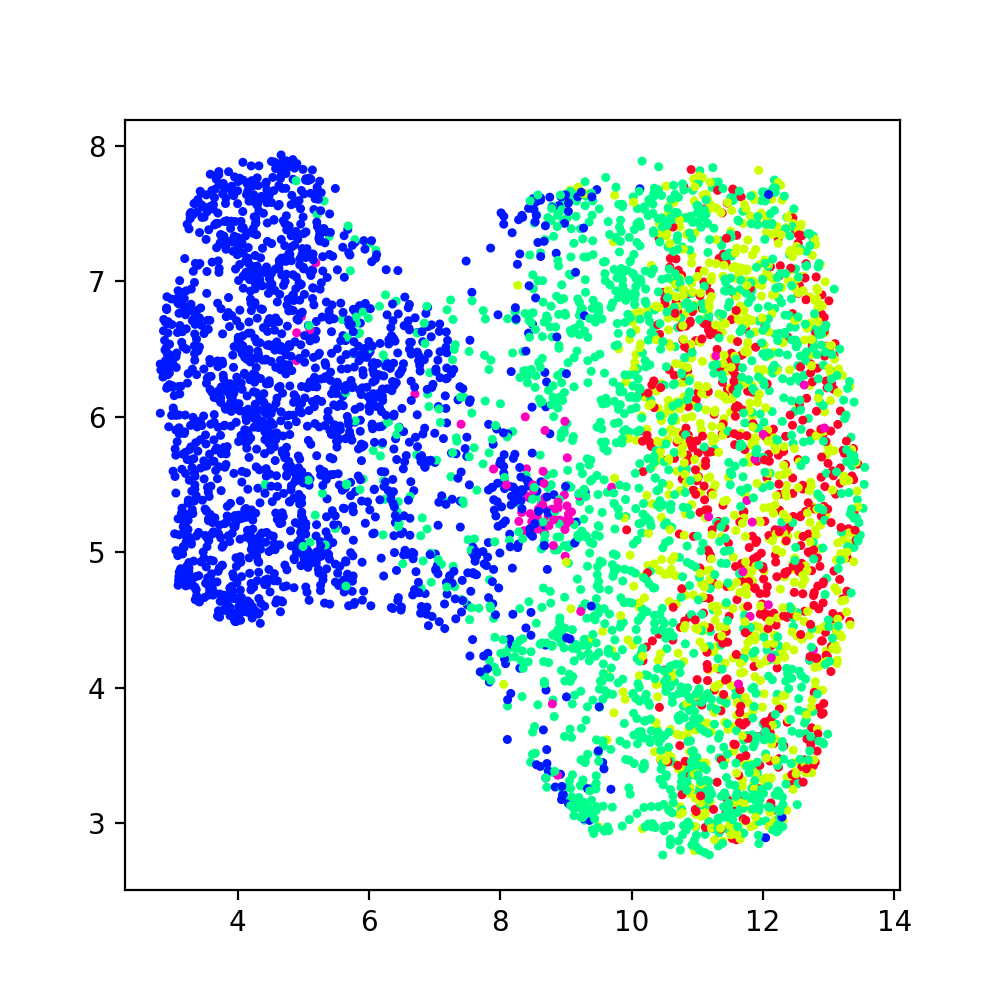

In [15]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.scatter(embeddings[:,0], embeddings[:,1], s=5, c=labelFiles[:], cmap='gist_rainbow')

In [16]:
toc['visualize'] = time.time() - tic

## Train/Holdout Split

In [17]:
from sklearn.model_selection import train_test_split
train_inx, holdout_inx = train_test_split(np.arange(latents.shape[0]), test_size=0.3)

In [18]:
features_train, features_holdout, labels_train, labels_holdout = (latents[train_inx],
                                                                  latents[holdout_inx],
                                                                  labelFiles[train_inx],
                                                                  labelFiles[holdout_inx],)

# Create Pipeline / Classifier

In [19]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

preproc = make_pipeline(
    StandardScaler(),
    PCA(),
)

preproc.fit(features_train, labels_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('pca', PCA())])

# Cross-Validation

In [20]:
# # Shuffle Split
# splitter = ShuffleSplit(n_splits=10)
# all_split_inx = list(splitter.split(features_train))

# # Train'/Val Extract
# trainp_X = [features_train[_[0]] for _ in all_split_inx]
# val_X = [features_train[_[1]] for _ in all_split_inx]
# trainp_y = [labels_train[_[0]] for _ in all_split_inx]
# val_y = [labels_train[_[1]] for _ in all_split_inx]

In [21]:
# Shuffle Split
splitter = ShuffleSplit(n_splits=10)
cv = crossval.CrossValidation(splitter)
cv.split_to_inx(features_train)
cv.inx_to_data(features_train, labels_train)

# Train'/Val Extract
# trainp_X = [features_train[_[0]] for _ in all_split_inx]
# val_X = [features_train[_[1]] for _ in all_split_inx]
# trainp_y = [labels_train[_[0]] for _ in all_split_inx]
# val_y = [labels_train[_[1]] for _ in all_split_inx]


In [22]:
# for ic, c in enumerate([100, 10, 1, 0.1, 0.01, 0.001]):
#     cm_train, cm_val, acc_train, acc_val = [], [], [], []
    
#     for tmp_trainp_X, tmp_trainp_y, tmp_val_X, tmp_val_y in tqdm(cv.get_inx_data()):
#         # Option 1: Fit Preprocessor from Scratch Each Time
#         tmp_pipe = make_pipeline(
#             StandardScaler(),
#             PCA(),
#             LogisticRegression(
#                 solver='lbfgs',
#                 fit_intercept=True, 
#                 class_weight='balanced',
#                 max_iter=10000,
#                 C=c
#             )
#         )
#         pipe = pipeline.Pipe(tmp_pipe)
#         pipe.pipeline.fit(tmp_trainp_X, tmp_trainp_y)
        
# #         # Option 2: Use a Preprocessor that was Pre-fit to All Data
# #         classify = LogisticRegression(
# #             solver='lbfgs',
# #             fit_intercept=True, 
# #             class_weight='balanced',
# #             max_iter=10000,
# #             C=c
# #         )
# #         classify.fit(preproc.transform(tmp_trainp_X), tmp_trainp_y)
# #         pipe = pipeline.Pipe(preproc, classify)
        
#         evaluator = evaluate.Evaluation(pipe.pipeline)
#         cm_train.append(evaluator.confusion_matrix(tmp_trainp_X, tmp_trainp_y))
#         cm_val.append(evaluator.confusion_matrix(tmp_val_X, tmp_val_y))
        
#         acc_train.append(evaluator.score_classifier_logreg(tmp_trainp_X, tmp_trainp_y))
#         acc_val.append(evaluator.score_classifier_logreg(tmp_val_X, tmp_val_y))
    
#     fig, ax = plt.subplots(1, 2, figsize=(10,3))
#     fig.suptitle(f'C: {c}')
#     sns.heatmap(np.round(np.mean(cm_train,axis=0),2), annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'), ax=ax[0])
#     ax[0].set_title(f'Train — Acc: {np.round(np.mean(acc_train, axis=0),2)}')
#     sns.heatmap(np.round(np.mean(cm_val,axis=0),2), annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'), ax=ax[1])
#     ax[1].set_title(f'Val — Acc: {np.round(np.mean(acc_val, axis=0),2)}')
    

In [40]:
res_dct = crossval.split_loop(cv,
                              preproc,
                              dict(solver='lbfgs', fit_intercept=True,  class_weight='balanced', max_iter=10000),
                              preproc_refit=False)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

'cm_0.001'

(array([[0.85, 0.21, 0.02, 0.  , 0.02],
        [0.14, 0.61, 0.14, 0.  , 0.  ],
        [0.01, 0.16, 0.72, 0.06, 0.  ],
        [0.  , 0.  , 0.06, 0.91, 0.02],
        [0.  , 0.02, 0.05, 0.03, 0.96]]),
 array([[0.81, 0.25, 0.02, 0.  , 0.  ],
        [0.17, 0.54, 0.14, 0.  , 0.  ],
        [0.01, 0.18, 0.71, 0.06, 0.08],
        [0.  , 0.  , 0.07, 0.91, 0.06],
        [0.  , 0.03, 0.06, 0.03, 0.86]]),
 0.81,
 0.77)

<IPython.core.display.Javascript object>


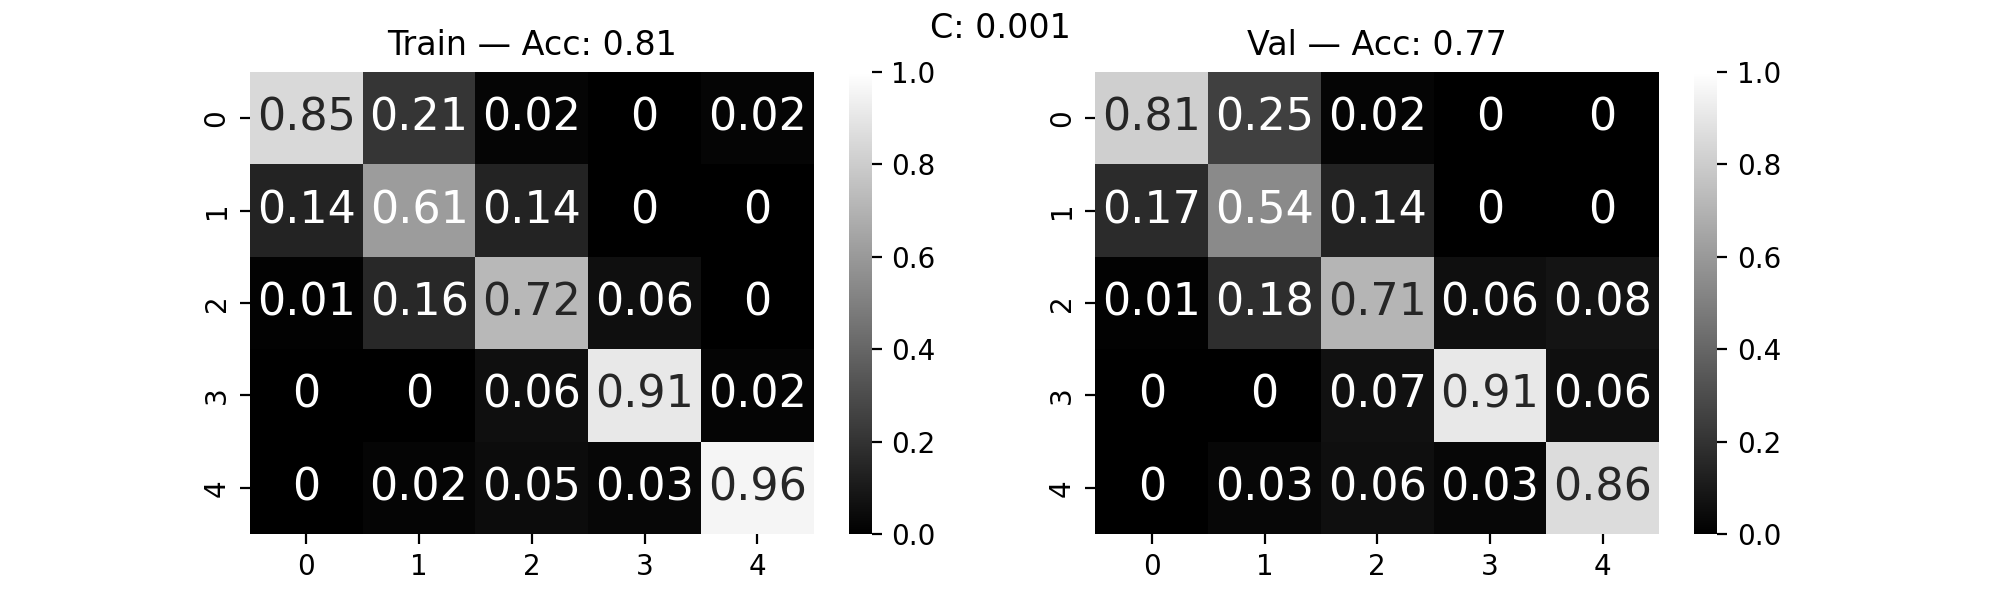

'cm_0.01'

(array([[0.86, 0.17, 0.01, 0.  , 0.  ],
        [0.14, 0.68, 0.14, 0.  , 0.  ],
        [0.01, 0.13, 0.77, 0.06, 0.  ],
        [0.  , 0.  , 0.06, 0.93, 0.  ],
        [0.  , 0.01, 0.03, 0.02, 1.  ]]),
 array([[0.81, 0.22, 0.01, 0.  , 0.  ],
        [0.18, 0.6 , 0.14, 0.  , 0.  ],
        [0.  , 0.16, 0.74, 0.07, 0.11],
        [0.  , 0.  , 0.07, 0.92, 0.06],
        [0.  , 0.01, 0.03, 0.02, 0.83]]),
 0.85,
 0.78)

<IPython.core.display.Javascript object>


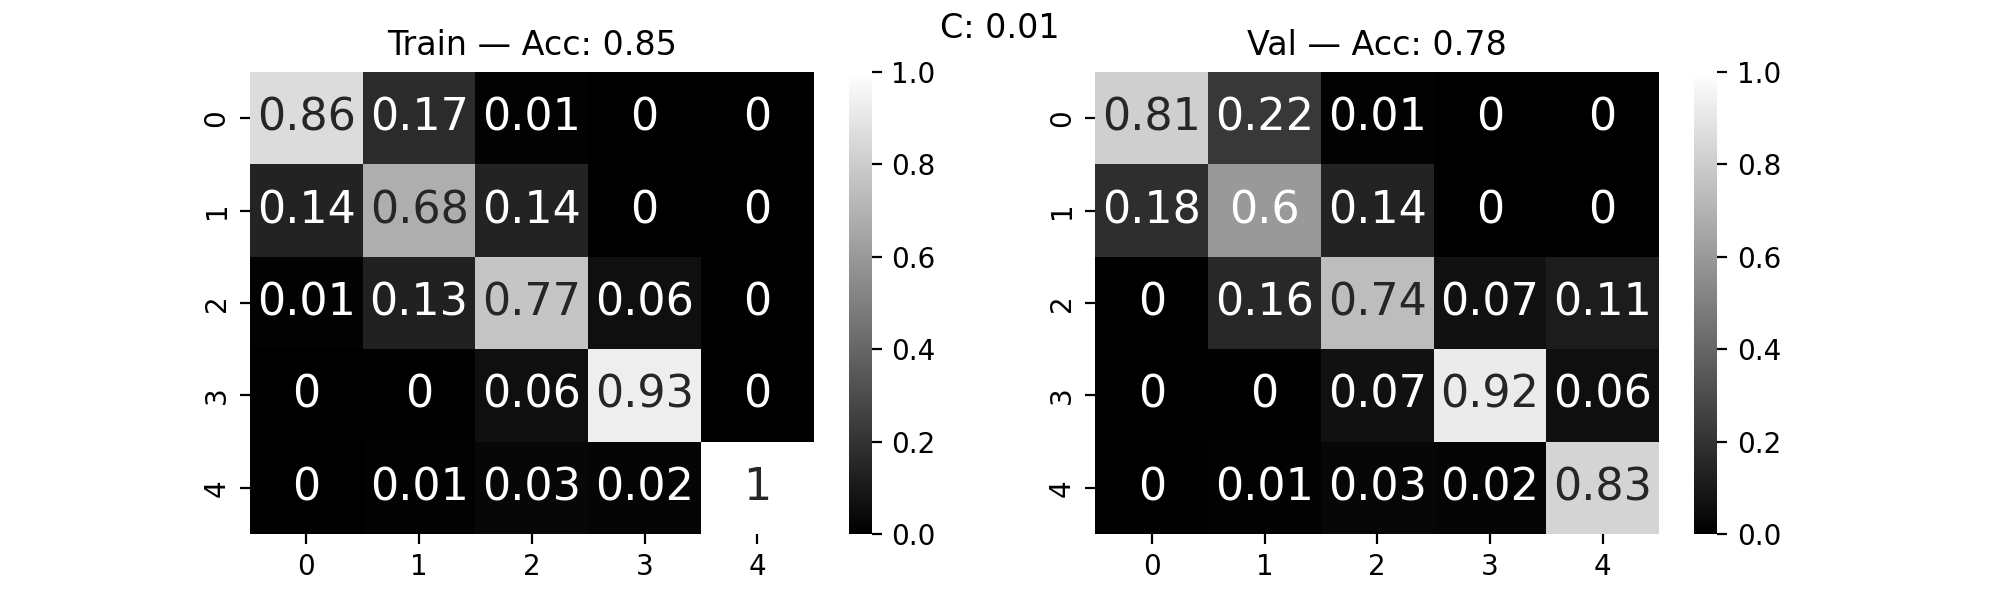

'cm_0.1'

(array([[0.87, 0.15, 0.01, 0.  , 0.  ],
        [0.13, 0.73, 0.13, 0.  , 0.  ],
        [0.  , 0.12, 0.81, 0.05, 0.  ],
        [0.  , 0.  , 0.04, 0.94, 0.  ],
        [0.  , 0.  , 0.01, 0.  , 1.  ]]),
 array([[0.8 , 0.22, 0.01, 0.  , 0.04],
        [0.2 , 0.61, 0.15, 0.  , 0.04],
        [0.  , 0.17, 0.76, 0.07, 0.16],
        [0.  , 0.  , 0.06, 0.92, 0.07],
        [0.  , 0.  , 0.02, 0.01, 0.69]]),
 0.87,
 0.75)

<IPython.core.display.Javascript object>


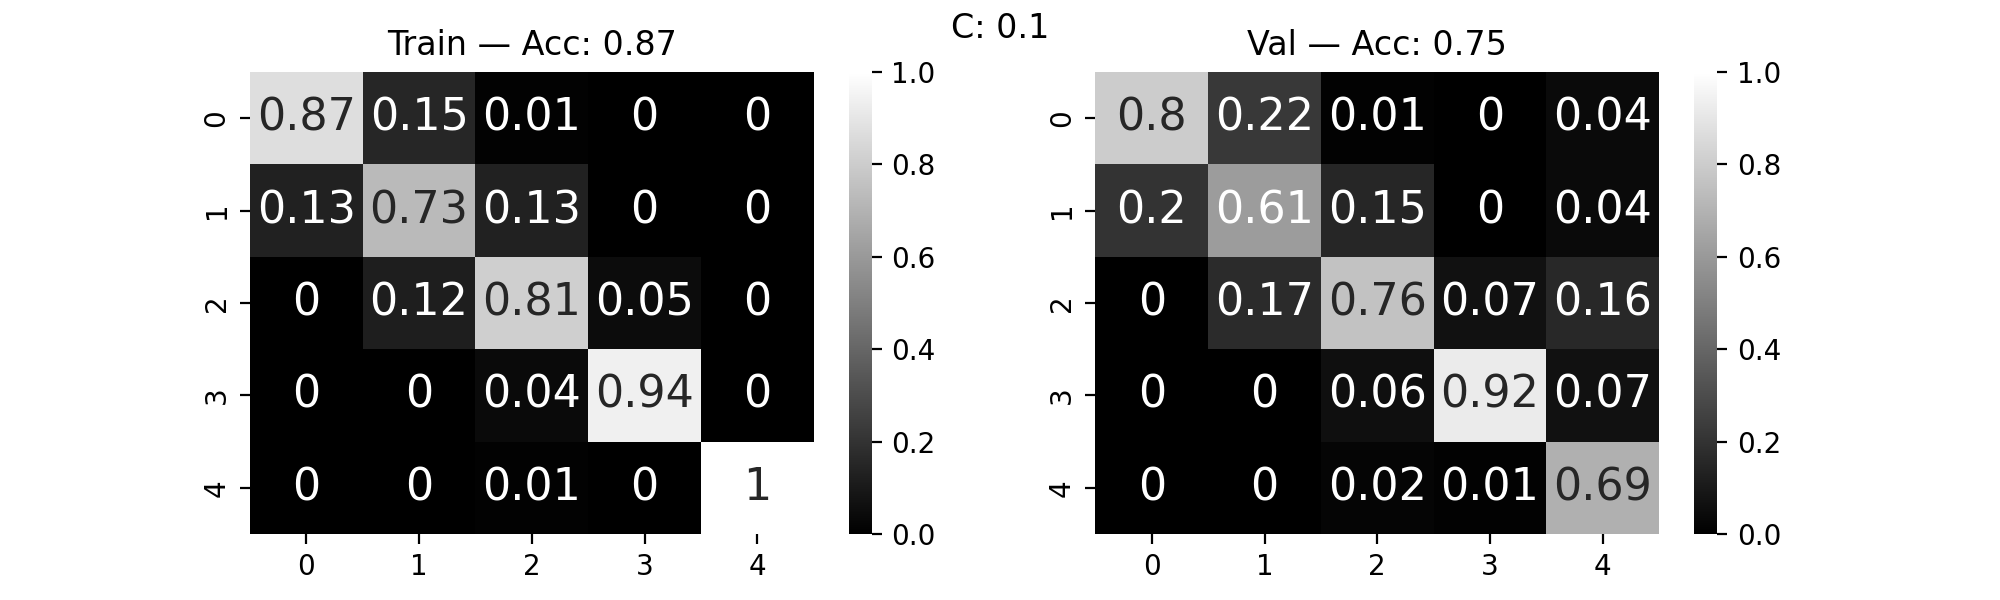

'cm_1'

(array([[0.87, 0.14, 0.  , 0.  , 0.  ],
        [0.13, 0.75, 0.13, 0.  , 0.  ],
        [0.  , 0.11, 0.83, 0.04, 0.  ],
        [0.  , 0.  , 0.04, 0.96, 0.  ],
        [0.  , 0.  , 0.  , 0.  , 1.  ]]),
 array([[0.8 , 0.21, 0.01, 0.  , 0.04],
        [0.2 , 0.62, 0.14, 0.  , 0.04],
        [0.01, 0.16, 0.78, 0.07, 0.23],
        [0.  , 0.  , 0.06, 0.92, 0.11],
        [0.  , 0.  , 0.02, 0.01, 0.58]]),
 0.88,
 0.74)

<IPython.core.display.Javascript object>


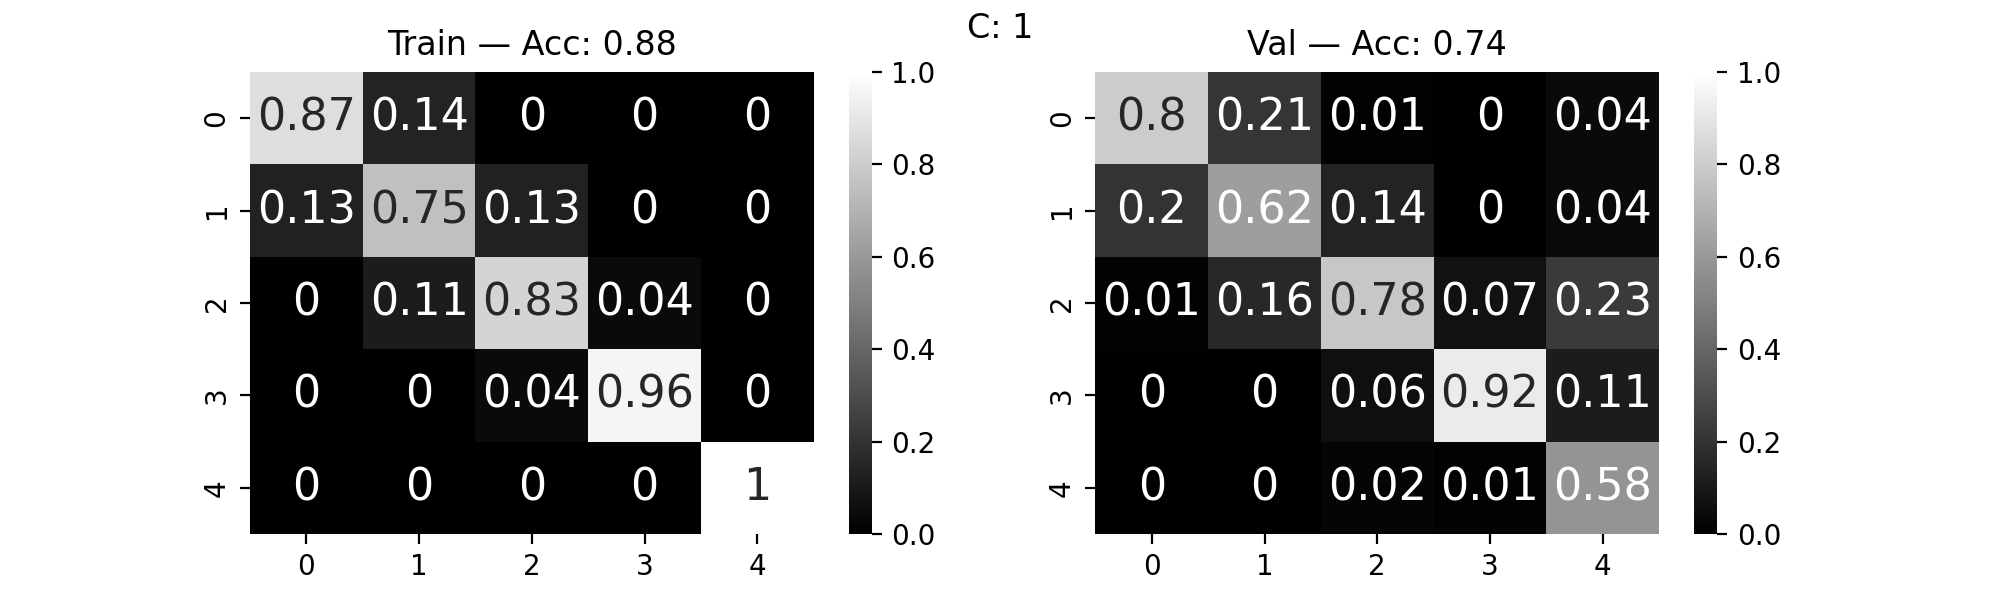

'cm_10'

(array([[0.87, 0.14, 0.01, 0.  , 0.  ],
        [0.13, 0.75, 0.13, 0.  , 0.  ],
        [0.  , 0.11, 0.83, 0.04, 0.  ],
        [0.  , 0.  , 0.04, 0.96, 0.  ],
        [0.  , 0.  , 0.  , 0.  , 1.  ]]),
 array([[0.79, 0.22, 0.01, 0.  , 0.04],
        [0.2 , 0.62, 0.14, 0.  , 0.06],
        [0.01, 0.16, 0.77, 0.06, 0.21],
        [0.  , 0.  , 0.06, 0.93, 0.13],
        [0.  , 0.  , 0.02, 0.  , 0.56]]),
 0.88,
 0.73)

<IPython.core.display.Javascript object>


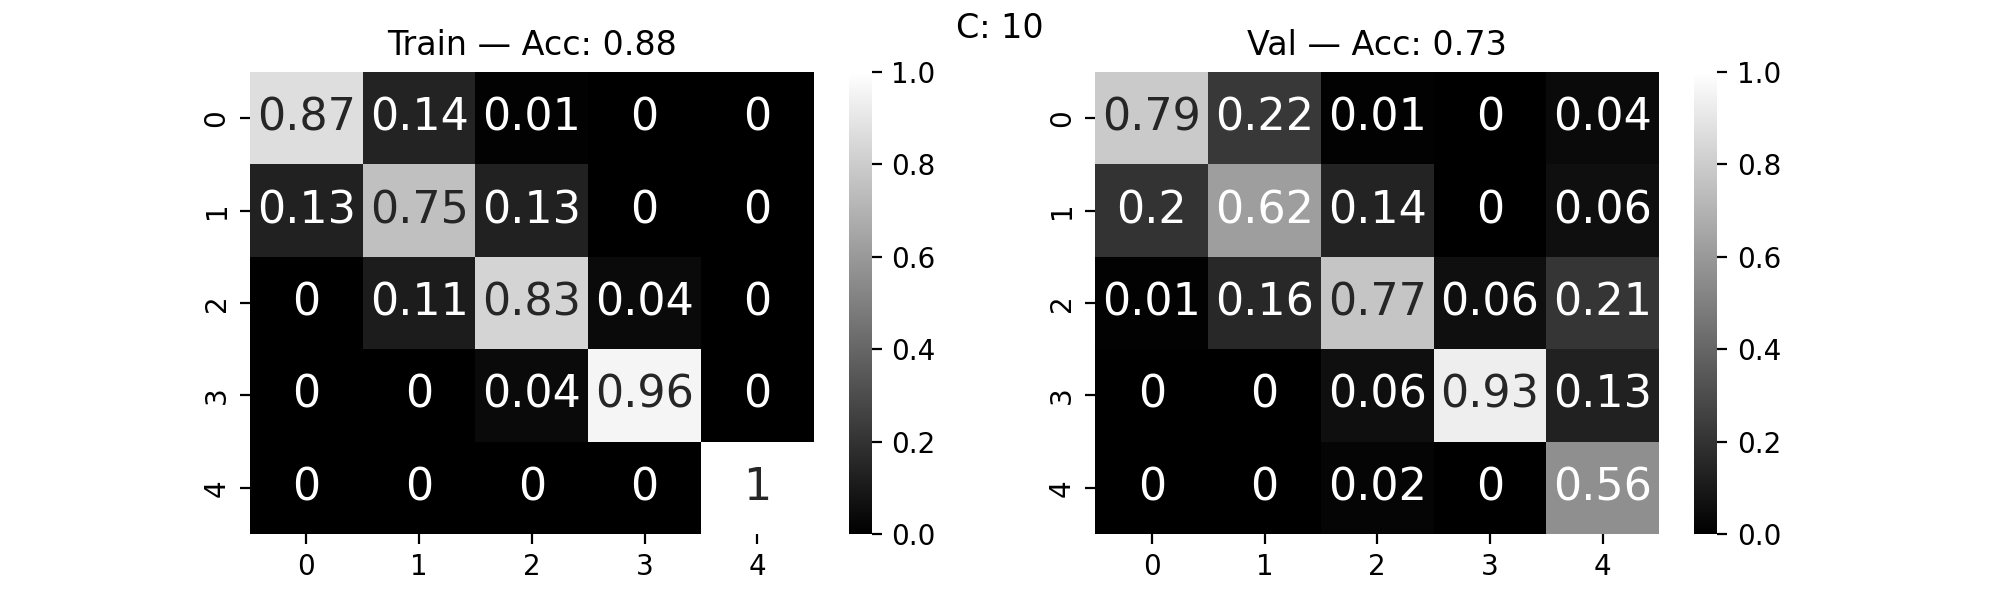

'cm_100'

(array([[0.87, 0.14, 0.01, 0.  , 0.  ],
        [0.13, 0.75, 0.13, 0.  , 0.  ],
        [0.  , 0.11, 0.83, 0.04, 0.  ],
        [0.  , 0.  , 0.04, 0.96, 0.  ],
        [0.  , 0.  , 0.  , 0.  , 1.  ]]),
 array([[0.79, 0.22, 0.01, 0.  , 0.06],
        [0.2 , 0.62, 0.14, 0.  , 0.06],
        [0.01, 0.16, 0.77, 0.06, 0.23],
        [0.  , 0.  , 0.06, 0.93, 0.11],
        [0.  , 0.  , 0.02, 0.  , 0.54]]),
 0.88,
 0.73)

<IPython.core.display.Javascript object>


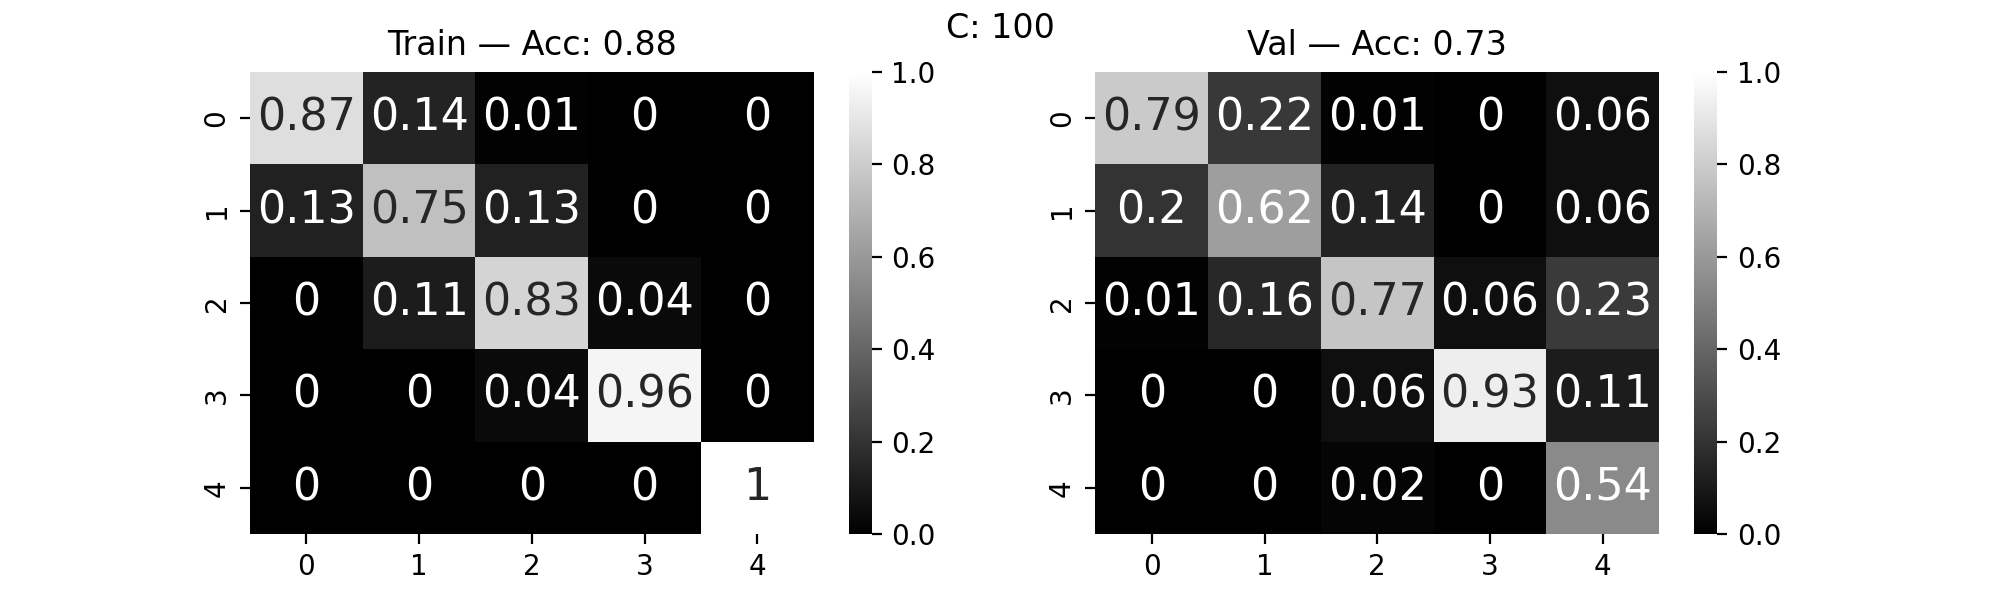

In [41]:
for k in sorted(list(res_dct.keys())):
    display(k, res_dct[k])
    if 'cm_' != k[:3]:
        continue
    c = k.replace('cm_','')
    fig, ax = plt.subplots(1, 2, figsize=(10,3))
    fig.suptitle(f'C: {c}')
    sns.heatmap(res_dct[k][0], annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'), ax=ax[0])
    sns.heatmap(res_dct[k][1], annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'), ax=ax[1])
    ax[0].set_title(f'Train — Acc: {res_dct[k][2]}')
    ax[1].set_title(f'Val — Acc: {res_dct[k][3]}')
    

# Refit Classifier

In [ ]:
preproc = make_pipeline(
    StandardScaler(),
    PCA(),
)

classify = LogisticRegression(
    solver='lbfgs',
    fit_intercept=True, 
    class_weight='balanced',
    max_iter=10000,
    C=1
)

preproc.fit(features_train, labels_train)
classify.fit(preproc.transform(features_train), labels_train)

pipe = pipeline.Pipe(preproc, classify)

# Evaluate Classifier

In [ ]:
evaluator = evaluate.Evaluation(pipe.pipeline)
cm = evaluator.confusion_matrix(features_train, labels_train)
cm = np.round(cm, 2)
fig, ax = plt.subplots(1, 1, figsize=(5,5))
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'), ax=ax)
fig.suptitle('Train')

In [ ]:
evaluator = evaluate.Evaluation(pipe.pipeline)
cm = evaluator.confusion_matrix(features_holdout, labels_holdout)
cm = np.round(cm, 2)
fig, ax = plt.subplots(1, 1, figsize=(5,5))
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'), ax=ax)
fig.suptitle('Holdout')

# Save Classifier

In [ ]:
preproc = make_pipeline(
    StandardScaler(),
    PCA(),
)

classify = LogisticRegression(
    solver='lbfgs',
    fit_intercept=True, 
    class_weight='balanced',
    max_iter=10000,
    C=1
)

preproc.fit(features_train, labels_train)
classify.fit(preproc.transform(features_train), labels_train)

pipe = pipeline.Pipe(preproc, classify)

In [ ]:
# Save Pipeline
pipe.save('/Users/josh/Downloads/data_backup_save/pipe2.pkl')
# pipe.save('/n/data1/hms/neurobio/sabatini/josh/analysis/data_backup_save/pipe.pkl')